# German Traffic Sign Recognition Benchmark - DNN Uncertainty

Disclaimer:

- Based on the code from: https://github.com/abursuc/dldiy-gtsr
- Dataset GTSRB pre-processed, images size: 32x32x3 RGB image

## General imports

In [70]:
import time
import os
import numpy as np
import torch
from PIL import Image
import imageio

import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary


import matplotlib.pyplot as plt
%matplotlib inline

## Custom Dataset

In [71]:
import os
import PIL as Image
import numpy as np
import torch

import torchvision.transforms as transforms

idx2label = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing for vehicles over 3.5 metric tons',
    11: 'Right-of-way at the next intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Vehicles over 3.5 metric tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve to the left',
    20: 'Dangerous curve to the right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End of all speed and passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 metric tons'
}

classnames = ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']



class GTSRBLoader(torch.utils.data.Dataset):

    def __init__(self, data_dir, split, custom_transforms=None, list_dir=None,
                 out_name=False,  crop_size=None, num_classes=43, phase=None):

        self.data_dir = data_dir
        self.split = split
        self.phase = split if phase is None else phase
        self.crop_size = 32 if crop_size is None else crop_size
        self.out_name = out_name
        self.idx2label = idx2label
        self.classnames = classnames

        self.num_classes = num_classes
        self.mean = np.array([0.3337, 0.3064, 0.3171])
        self.std = np.array([0.2672, 0.2564, 0.2629])
        self.image_list, self.label_list = None, None
        self.read_lists()
        self.transforms = self.get_transforms(custom_transforms)


    def __getitem__(self, index):
        im = Image.open(f'{self.data_dir}/{self.image_list[index]}')
        data = [self.transforms(im)]
        data.append(self.label_list[index])
        if self.out_name:
            data.append(self.image_list[index])
        return tuple(data)

    def __len__(self):
        return len(self.image_list)

    def get_transforms(self, custom_transforms):
        if custom_transforms:
            return custom_transforms

        if 'train' == self.phase:
            return transforms.Compose([
                transforms.Resize((self.crop_size, self.crop_size)),
                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0),
                transforms.ToTensor(),
                transforms.Normalize(mean=self.mean, std=self.std),
            ])
        else:
            return transforms.Compose([
                transforms.Resize((self.crop_size, self.crop_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=self.mean, std=self.std),
            ])


    def read_lists(self):
        image_path = os.path.join(self.data_dir, self.split + '_images.txt')
        assert os.path.exists(image_path)
        self.image_list = [line.strip().split()[0] for line in open(image_path, 'r')]
        self.label_list = [int(line.strip().split()[1]) for line in open(image_path, 'r')]
        assert len(self.image_list) == len(self.label_list)


    # get raw image prior to normalization
    # expects input image as torch Tensor
    def unprocess_image(self, im, plot=False):
        im = im.squeeze().numpy().transpose((1, 2, 0))
        im = self.std * im + self.mean
        im = np.clip(im, 0, 1)
        im = im * 255
        im = Image.fromarray(im.astype(np.uint8))

        if plot:
            plt.imshow(im)
            plt.show()
        else:
            return im

    # de-center images and bring them back to their raw state
    def unprocess_batch(self, input):
        for i in range(input.size(1)):
            input[:,i,:,:] = self.std[i] * input[:,i,:,:]
            input[:,i,:,:] = input[:,i,:,:] + self.mean[i]
            input[:,i,:,:] = np.clip(input[:,i,:,:], 0, 1)

        return input


## Helper Functions

__Helper funtion to show unnormalized sample images__

In [72]:
def showImage(img, title=None):
    mean = np.array([0.3337, 0.3064, 0.3171])
    std = np.array([0.2672, 0.2564, 0.2629])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)


## Models

### LeNet-5

In [104]:
import torch.nn as nn
import torch.nn.functional as F


class LeNet(nn.Module):
    def __init__(self, num_classes=43, input_channels=3):

        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear((16 * 5 * 5), 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)

        if 1 == num_classes:
            # compatible with nn.BCELoss
            self.softmax = nn.Sigmoid()
        else:
            # compatible with nn.CrossEntropyLoss
            self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)

        out = self.softmax(out)
        return out


def lenet5(**kwargs):
    model = LeNet(**kwargs)
    return model


def lenet(model_name, num_classes, input_channels, pretrained=False):
    return{
        'lenet5': lenet5(num_classes=num_classes, input_channels=input_channels),
    }[model_name]


### LeNet-5 with Dropout

In [94]:
import torch.nn as nn
import torch.nn.functional as F


class LeNetDropout(nn.Module):
    def __init__(self, num_classes=43, input_channels=3):

        super(LeNetDropout, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear((16 * 5 * 5), 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)
        
        self.dropout_05 = nn.Dropout(p=0.5)
        self.dropout_025 = nn.Dropout(p=0.25)

        if 1 == num_classes:
            # compatible with nn.BCELoss
            self.softmax = nn.Sigmoid()
        else:
            # compatible with nn.CrossEntropyLoss
            self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        
        out = out.view(out.size(0), -1)
        
        out = F.relu(self.fc1(out))
        out = self.dropout_05(out)
        
        out = F.relu(self.fc2(out))
        out = self.dropout_025(out)
        
        out = self.fc3(out)

        out = self.softmax(out)
        return out


## Build Dataloaders

In [75]:
from PIL import Image
import imageio

In [76]:
dataset_train = GTSRBLoader('../data/gtsrb-data', split='train', phase='train',
                            num_classes=43, crop_size=32)

In [77]:
len(dataset_train)

35600

In [78]:
dataset_val = GTSRBLoader('../data/gtsrb-data', split='val', phase='test',
                            num_classes=43, crop_size=32)

In [79]:
len(dataset_val)

3609

In [80]:
dataset_test = GTSRBLoader('../data/gtsrb-data', split='test', phase='test',
                            num_classes=43, crop_size=32)

In [81]:
len(dataset_test)

1273

In [82]:
train_loader = torch.utils.data.DataLoader(dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=8,
                                           pin_memory=True)

validation_loader = torch.utils.data.DataLoader(dataset_train,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=8,
                                           pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=8,
                                           pin_memory=True)

### Sample train loader

In [83]:
batch_iter = iter(train_loader)
images_batch, labels_batch = batch_iter.next()
image = images_batch[0]

Convert to numpy and Check the shape of the array, it should be (channels, height, width)

In [84]:
image = image.numpy()
image.shape

(3, 32, 32)

Reshape image to (height, width, channels):

In [85]:
image_reshaped = np.rollaxis(image,0,3)
image_reshaped.shape

(32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


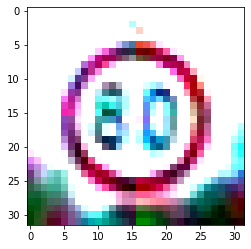

In [86]:
img = np.array(image_reshaped)

plt.imshow(img)
plt.show()

## Trainer & Test - LeNet Model

### Training settings

In [100]:
epochs = 20
learning_rate = 0.001

### Check GPU availability

In [101]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == "cuda":
    device_name = "CUDA"
else:
    device_name = "CPU"

print("% s will be used for training/testing" % device_name)

CUDA will be used for training/testing


### Model Instance

In [111]:
# model = LeNet()
model = LeNetDropout()
print(model)

LeNetDropout(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=43, bias=True)
  (dropout_05): Dropout(p=0.5, inplace=False)
  (dropout_025): Dropout(p=0.25, inplace=False)
  (softmax): LogSoftmax()
)


### Criterion

Use Negative LogLikelihood

In [112]:
criterion = nn.NLLLoss()

### Optimazer

In [113]:
optimizer = torch.optim.Adam(model.parameters(),
                            lr=learning_rate,
                            amsgrad=False)

### Training & Validation loop

In [114]:
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

epoch_avg_train_losses = []
epoch_avg_eval_losses = []

for epoch in range(epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.to(device)
    model.train() # prep model for training
    
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.to(device)
    model.eval() # prepare model for evaluation
    
    with torch.no_grad():
        for data, target in validation_loader:
            data = data.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update running validation loss 
            valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(validation_loader.sampler)
    
    # append epoch average losses
    epoch_avg_train_losses.append(train_loss)
    epoch_avg_eval_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.554163 	Validation Loss: 1.119072
Validation loss decreased (inf --> 1.119072).  Saving model ...
Epoch: 2 	Training Loss: 1.116921 	Validation Loss: 0.574079
Validation loss decreased (1.119072 --> 0.574079).  Saving model ...
Epoch: 3 	Training Loss: 0.768853 	Validation Loss: 0.383347
Validation loss decreased (0.574079 --> 0.383347).  Saving model ...
Epoch: 4 	Training Loss: 0.589621 	Validation Loss: 0.262288
Validation loss decreased (0.383347 --> 0.262288).  Saving model ...
Epoch: 5 	Training Loss: 0.490676 	Validation Loss: 0.224666
Validation loss decreased (0.262288 --> 0.224666).  Saving model ...
Epoch: 6 	Training Loss: 0.424278 	Validation Loss: 0.183093
Validation loss decreased (0.224666 --> 0.183093).  Saving model ...
Epoch: 7 	Training Loss: 0.378027 	Validation Loss: 0.140883
Validation loss decreased (0.183093 --> 0.140883).  Saving model ...
Epoch: 8 	Training Loss: 0.332458 	Validation Loss: 0.114252
Validation loss decreased (0.14088

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt

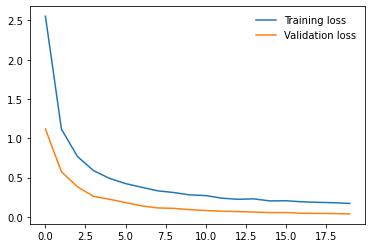

In [116]:
plt.plot(epoch_avg_train_losses, label='Training loss')
plt.plot(epoch_avg_eval_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

### Test Loop

In [117]:
test_loss = 0.0
class_correct = list(0. for i in range(43))
class_total = list(0. for i in range(43))


In [118]:
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

In [119]:
print(target.data[1])

tensor(3, device='cuda:0')


In [120]:
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(43):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.037802

Test Accuracy of     0: 95% (114/120)
Test Accuracy of     1: 98% (2107/2130)
Test Accuracy of     2: 98% (2138/2160)
Test Accuracy of     3: 99% (1309/1320)
Test Accuracy of     4: 98% (1869/1890)
Test Accuracy of     5: 97% (1723/1770)
Test Accuracy of     6: 99% (329/330)
Test Accuracy of     7: 98% (1323/1350)
Test Accuracy of     8: 98% (1300/1320)
Test Accuracy of     9: 98% (1357/1380)
Test Accuracy of    10: 99% (1917/1920)
Test Accuracy of    11: 99% (1223/1230)
Test Accuracy of    12: 99% (2009/2010)
Test Accuracy of    13: 99% (2068/2070)
Test Accuracy of    14: 100% (690/690)
Test Accuracy of    15: 99% (535/540)
Test Accuracy of    16: 99% (329/330)
Test Accuracy of    17: 99% (1019/1020)
Test Accuracy of    18: 99% (1101/1110)
Test Accuracy of    19: 85% (102/120)
Test Accuracy of    20: 94% (254/270)
Test Accuracy of    21: 97% (235/240)
Test Accuracy of    22: 100% (300/300)
Test Accuracy of    23: 99% (417/420)
Test Accuracy of    24: 97% (175/180)

### Get Model Summary

```python
summary(your_model, input_size=(channels, H, W))
```

In [121]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
           Dropout-4                  [-1, 120]               0
            Linear-5                   [-1, 84]          10,164
           Dropout-6                   [-1, 84]               0
            Linear-7                   [-1, 43]           3,655
        LogSoftmax-8                   [-1, 43]               0
Total params: 64,811
Trainable params: 64,811
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


## Sample test

### Get images from a batch

In [122]:
batch_iter = iter(test_loader)
images_batch, labels_batch = batch_iter.next()
image = images_batch[0]
image_tensor = image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


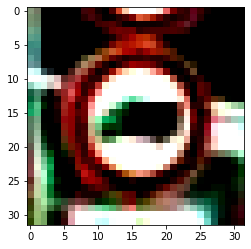

In [123]:
image_numpy = image_tensor.numpy()
image_numpy.shape

image_reshaped = np.rollaxis(image_numpy,0,3)
image_reshaped.shape


img = np.array(image_reshaped)

plt.imshow(img)
plt.show()

__Unnormalize the sample image__

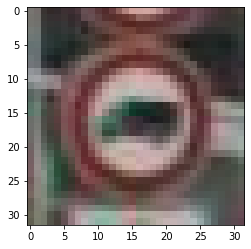

In [124]:
showImage(img)

In [125]:
label = labels_batch[0].numpy()
idx2label[int(label)]

'Vehicles over 3.5 metric tons prohibited'

### Model Predictions

__Send only one sampel to the model__

In [126]:
image = image.to(device)

output = model(image[None])

_, predicted = torch.max(output.data, 1)
predicted[0]

tensor(16, device='cuda:0')

__Get model Prediction__

In [127]:
prediction = predicted[0].cpu()
label = prediction.numpy()
idx2label[int(label)]

'Vehicles over 3.5 metric tons prohibited'

__Get Model Top5 Predictions__

Prediction values are not normalized ([0, 1]) in the output, since we are using $Ln(Softmax(x))$ in the last layer to match the loss-function expected input.

In [128]:
top5_predictions = torch.topk(output.data[0], 5)
top5_predictions

torch.return_types.topk(
values=tensor([  0.0000, -18.7643, -19.4702, -25.7209, -29.7032], device='cuda:0'),
indices=tensor([16,  7,  9, 42, 10], device='cuda:0'))

__Get Softmax probabilities from the Top5 Predictions for the sample image__

In [129]:
top5_predictions_probs = [np.exp(i) for i in top_predictions[0].cpu()]
top5_predictions_probs

[tensor(1.),
 tensor(6.4293e-11),
 tensor(3.7813e-11),
 tensor(4.6859e-13),
 tensor(2.0167e-13)]

__Get Labels from the Top5 Predictions for the sample image__

In [130]:
predictions = top5_predictions[1].cpu()
preds = predictions.numpy()
pred_labels = [idx2label[i] for i in preds]
pred_labels

['Vehicles over 3.5 metric tons prohibited',
 'Speed limit (100km/h)',
 'No passing',
 'End of no passing by vehicles over 3.5 metric tons',
 'No passing for vehicles over 3.5 metric tons']

#### Output Plot

In [59]:
def y_predict_model(Input_data, top_k=5):
    """
    Generates the predictions of the model over the input data, and outputs the top softmax probabilities.
        Parameters:
            X_data: Input data.
            top_k (Default = 5): The number of top softmax probabilities to be generated.
    """
    num_examples = len(Input_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.Session() as sess:
        VGGNet_Model.saver.restore(sess, os.path.join(DIR, "VGGNet"))
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(VGGNet_Model.logits), k=top_k), 
                             feed_dict={x:Input_data, keep_prob:1, keep_prob_conv:1})
    return y_prob, y_pred

In [131]:
y_prob, y_pred = y_predict_model(new_test_images_preprocessed)

test_accuracy = 0
for i in enumerate(new_test_images_preprocessed):
    accu = new_IDs[i[0]] == np.asarray(y_pred[i[0]])[0]
    if accu == True:
        test_accuracy += 0.2
print("New Images Test Accuracy = {:.1f}%".format(test_accuracy*100))

plt.figure(figsize=(15, 16))
new_test_images_len=len(new_test_images_preprocessed)
for i in range(new_test_images_len):
    plt.subplot(new_test_images_len, 2, 2*i+1)
    plt.imshow(new_test_images[i]) 
    plt.title(signs[y_pred[i][0]])
    plt.axis('off')
    plt.subplot(new_test_images_len, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), y_prob[i, :])
    labels = [signs[j] for j in y_pred[i]]
    plt.yticks(np.arange(1, 6, 1), labels)
plt.show()

NameError: name 'y_predict_model' is not defined

## Monte-Carlo Dropout

### Enable Dropout during testing

In [134]:
def apply_dropout(m):
    if type(m) == nn.Dropout:
        m.train()

In [133]:
# Apply dropout on testing 
model.apply(apply_dropout)

LeNetDropout(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=43, bias=True)
  (dropout_05): Dropout(p=0.5, inplace=False)
  (dropout_025): Dropout(p=0.25, inplace=False)
  (softmax): LogSoftmax()
)

### Define the Number of Stochastic Forward passes for each input sample

In [135]:
# Nro of Forward passes
T = 20
predictions = []

### Predictions

In [147]:
predictionValuesFWPass = [torch.max(model(image[None]).data, 1) for t in range(T)]
predictionValuesFWPass

[torch.return_types.max(
 values=tensor([0.], device='cuda:0'),
 indices=tensor([16], device='cuda:0')),
 torch.return_types.max(
 values=tensor([-0.0026], device='cuda:0'),
 indices=tensor([16], device='cuda:0')),
 torch.return_types.max(
 values=tensor([-9.9182e-05], device='cuda:0'),
 indices=tensor([16], device='cuda:0')),
 torch.return_types.max(
 values=tensor([0.], device='cuda:0'),
 indices=tensor([16], device='cuda:0')),
 torch.return_types.max(
 values=tensor([0.], device='cuda:0'),
 indices=tensor([16], device='cuda:0')),
 torch.return_types.max(
 values=tensor([-0.0031], device='cuda:0'),
 indices=tensor([16], device='cuda:0')),
 torch.return_types.max(
 values=tensor([-0.0198], device='cuda:0'),
 indices=tensor([16], device='cuda:0')),
 torch.return_types.max(
 values=tensor([0.], device='cuda:0'),
 indices=tensor([16], device='cuda:0')),
 torch.return_types.max(
 values=tensor([-0.0024], device='cuda:0'),
 indices=tensor([16], device='cuda:0')),
 torch.return_types.max(
 

In [142]:
image = image.to(device)

output = model(image[None])

_, predicted = torch.max(output.data, 1)
predicted[0]

prediction = predicted[0].cpu()
label = prediction.numpy()
idx2label[int(label)]

'Vehicles over 3.5 metric tons prohibited'